# Using the Script-Language Container
A [Script-Language Container](https://github.com/exasol/script-languages-release) for the Exasol database consists of a Linux container with a complete Linux distribution and all required libraries, such as a script client. The script client is responsible for the communication with the  database and for executing the script code. It allows to also include user specific libraries which can then be used from within the UDF's. 

Before we start we need to configure the script-languages directory and flavor. See [Configure SLC Flavor](./configure_slc_flavor.ipynb)

## Setup
### Open Secure Configuration Storage

In [18]:
%run ../utils/access_store_ui.ipynb
display(get_access_store_ui('../'))

Output()

Box(children=(Box(children=(Label(value='Configuration Store', layout=Layout(border_bottom='solid 1px', border…

### Utility functions

#### Working directory context manager
Let's create a utility context manager function which enters a directory and jumps back to the previous directory on exit.

In [19]:
import os
import contextlib
from pathlib import Path

@contextlib.contextmanager
def working_directory(path: Path):
    """Changes working directory and returns to previous on exit."""
    prev_cwd = Path.cwd()
    os.chdir(path)
    try:
        yield
    finally:
        os.chdir(prev_cwd)

### Import some utility functions

In [24]:
from exasol.nb_connector.utils import upward_file_search

# This NB may be running from various locations in the NB hierarchy.
# Need to search for the styles NB from the current directory upwards.

%run {upward_file_search('utils/ui_styles.ipynb')}
%run {upward_file_search('utils/popup_message_ui.ipynb')}
%run ./utils/file_system_ui.ipynb



Output()

## Let's use the flavor as is
### Check selected flavor path

In [5]:
from pathlib import Path
slc_source_flavor_store_key = "slc_flavor"
slc_target_dir_store_key = "slc_target_dir"

slc_dir = Path(ai_lab_config.get(slc_target_dir_store_key))
selected_flavor = ai_lab_config.get(slc_source_flavor_store_key)
print(f"Script-languages repository path is '{slc_dir}'")
print(f"Selected flavor is '{selected_flavor}'")
if not (Path(slc_dir) / "flavors" / selected_flavor).is_dir():
    popup_message("Invalid script-languages directory or flavor configuration. Please re-run ")

flavor_path = Path("flavors") / selected_flavor


Script-languages repository path is '/home/jupyter/notebooks/script_languages_release'
Selected flavor is 'template-Exasol-all-python-3.10'


### Export the flavor
You could run the same on the command line with the `exaslct` tool:
```
cd <slc_dir>
./exaslct export --flavor-path flavors/<flavor_path>
```

In [27]:
from exasol_script_languages_container_tool.lib import api as exaslct_api

export_path = "/home/jupyter/notebooks/script_languages_container/container"
output_path = "/home/jupyter/notebooks/script_languages_container/output"


with working_directory(slc_dir):
    export_result = exaslct_api.export(flavor_path=(str(flavor_path),), export_path=export_path, output_directory=output_path)
print("Ready")

Ready


#### Check the result

In [23]:
print(f"Result file: {export_result.export_infos[str(flavor_path)]['release'].output_file}")
print("Directory content:")
show_directory_content(Path(export_path))

Result file: /home/jupyter/notebooks/slc/template-Exasol-all-python-3.10_release.tar.gz
Directory content:


/home/jupyter/notebooks/slc/template-Exasol-all-python-3.10_release.tar.gz

/home/jupyter/notebooks/slc/template-Exasol-all-python-3.10_release.tar.gz.sha512sum

### What to do if something doesn't work?

During the build it can happen that external package repositories might not be available or something is wrong on your machine where you run the build. For these cases, exaslct stores many logs to identify the problem.

#### Exaslsct Log
The main log for exaslct is stored directly as main.log in the build output of the job. With the following command you can find the main logs for all previous executions.

In [28]:
build_output = Path(output_path)
main_logs = list(build_output.glob('**/main.log'))
show_files(main_logs)

/home/jupyter/notebooks/script_languages_container/output/jobs/2024_06_21_14_53_05_2_ExportContainers/logs/main.log

With the following command you can show the log file from the last execution.                    

In [22]:
tail_file(main_logs[0], 20)

2024-06-21 08:54:46,299 - luigi.scheduler - DEBUG - Done pruning task graph
2024-06-21 08:54:46,299 - luigi-interface - DEBUG - Done
2024-06-21 08:54:46,299 - luigi-interface - DEBUG - There are no more tasks to run at this time
2024-06-21 08:54:46,299 - luigi-interface - INFO - Worker Worker(salt=6340760915, workers=5, host=9e659425cf04, username=root, pid=369, sudo_user=ubuntu) was stopped. Shutting down Keep-Alive thread
2024-06-21 08:54:46,308 - luigi-interface - INFO - 
===== Luigi Execution Summary =====

Scheduled 13 tasks of which:
* 13 ran successfully:
    - 1 AnalyzeBuildDeps_c91a290a4b(job_id=2024_06_21_08_52_13_1_ExportContainers, no_cache=False, flavor_path=flavors/template-Exasol-all-python-3.10)
    - 1 AnalyzeBuildRun_c91a290a4b(job_id=2024_06_21_08_52_13_1_ExportContainers, no_cache=False, flavor_path=flavors/template-Exasol-all-python-3.10)
    - 1 AnalyzeFlavorBaseDeps_c91a290a4b(job_id=2024_06_21_08_52_13_1_ExportContainers, no_cache=False, flavor_path=flavors/temp

#### Build Output Directory

More detailed information about the build or other operations can be found in the `.build_output/jobs/*/outputs` directory. Here each run of `exaslct` creates its own directory under `.build_output/jobs`. The outputs directory stores the outputs and log files (if any) that each executed task of `exaslct` produces. Especially, the Docker tasks such as build, pull and push store the logs returned by the Docker API. This can be helpful for finding problems during the build.

In [29]:
all_logs = list(build_output.glob('**/*.log'))
show_files(all_logs)

/home/jupyter/notebooks/script_languages_container/output/jobs/2024_06_21_14_53_05_2_ExportContainers/logs/main.log

/home/jupyter/notebooks/script_languages_container/output/jobs/2024_06_21_14_53_05_2_ExportContainers/logs/.ipynb_checkpoints/main-checkpoint.log

/home/jupyter/notebooks/script_languages_container/output/jobs/2024_06_21_14_53_05_2_ExportContainers/outputs/ExportContainers_fa5202c5a0/ExportFlavorContainer_a82bda8b22/ExportContainerTask_d268348ae6/logs/pack_release_file.log

/home/jupyter/notebooks/script_languages_container/output/jobs/2024_06_21_14_53_05_2_ExportContainers/outputs/ExportContainers_fa5202c5a0/ExportFlavorContainer_a82bda8b22/ExportContainerTask_d268348ae6/logs/extract_release_file.log

## Customizing Script-Language Containers
Sometimes you need very specific dependencies or versions of dependencies in the Exasol UDFs. In such case you can customize a Script-Language Container.
### Flavor Definition
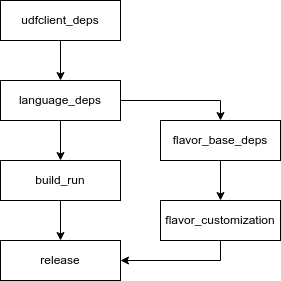


For customizing a flavor usually the flavor_customization build step is most important. It contains everything you need to add dependencies. The remaining build steps should be only changed with care, but sometimes some dependencies are defined in other build steps because the script client depends on them. 
Let's check the directory structure of the selected flavor.

In [24]:
show_directory_content(slc_dir / flavor_path, 2)

/home/jupyter/script_languages_release/flavors/template-Exasol-all-python-3.10/flavor_customization
/home/jupyter/script_languages_release/flavors/template-Exasol-all-python-3.10/flavor_customization/packages
/home/jupyter/script_languages_release/flavors/template-Exasol-all-python-3.10/flavor_customization/Dockerfile
/home/jupyter/script_languages_release/flavors/template-Exasol-all-python-3.10/FLAVOR_DESCRIPTION.md
/home/jupyter/script_languages_release/flavors/template-Exasol-all-python-3.10/flavor_base
/home/jupyter/script_languages_release/flavors/template-Exasol-all-python-3.10/flavor_base/testconfig
/home/jupyter/script_languages_release/flavors/template-Exasol-all-python-3.10/flavor_base/base_test_build_run
/home/jupyter/script_languages_release/flavors/template-Exasol-all-python-3.10/flavor_base/security_scan
/home/jupyter/script_languages_release/flavors/template-Exasol-all-python-3.10/flavor_base/release
/home/jupyter/script_languages_release/flavors/template-Exasol-all-pyth

### Flavor Customization Build Step

The **flavor_customization** build step consists of a Dockerfile and several package lists which can be modified. We recommend to use the package lists to add new packages to the flavor and only modify the Dockerfile if you need very specific changes, like adding additional resources.

In [25]:
show_directory_content(slc_dir / flavor_path / "flavor_customization")

/home/jupyter/script_languages_release/flavors/template-Exasol-all-python-3.10/flavor_customization/packages
/home/jupyter/script_languages_release/flavors/template-Exasol-all-python-3.10/flavor_customization/Dockerfile


#### Dockerfile
The Dockerfile consists of two parts. The first part installs the packages from the package list and should only be change with care. The second part is free for your changes. Read the description in the Dockerfile carefully to find out what you can and shouldn't do.

In [27]:
show_docker_file(slc_dir / flavor_path / "flavor_customization" / "Dockerfile")

############################################################################################
############################################################################################
# This Dockerfile allows you to extend this flavor by installing packages or adding files. 
# IF you didn't change the lines below, you can add packages and their version to the  
# files in ./packages and they get automatically installed.                                
############################################################################################
############################################################################################

#######################################################################
#######################################################################
# Do not change the following lines unless you know what you are doing 
#######################################################################
#######################################################################

FROM {{flavor_base_deps}}

RUN mkdir -p /build_info/packages/flavor_customization

COPY flavor_customization/packages/apt_get_packages /build_info/packages/flavor_customization
RUN /scripts/install_scripts/install_via_apt.pl --file /build_info/packages/flavor_customization/apt_get_packages --with-versions

COPY flavor_customization/packages/python3_pip_packages /build_info/packages/flavor_customization
RUN /scripts/install_scripts/install_via_pip.pl --file /build_info/packages/flavor_customization/python3_pip_packages --python-binary python3 --with-versions --allow-no-version


##########################################################################
##########################################################################
# Below this text you can add any Dockerfile commands except of FROM.            
# However only commands which change the filesystem will be              
# reflected to the final script-language container.                      
# We recommend to use only RUN, COPY and ADD. For example, WORKDIR, USER 
# and ENV will be not carried over into the final container. For more 
# information about Dockerfile commands, please check the reference 
# https://docs.docker.com/engine/reference/builder/#dockerfile-reference 
##########################################################################
##########################################################################


###########
###########
# Examples:
###########
###########

#################################################
# Execute a command during the build of the image
#################################################

# With RUN you can excute any command you usally would run in a bash shell.
# It usually is a good idea to cleanup downloaded files or packages 
# caches in the same in the same RUN statement to keep the image size
# small. You can execute multiple shell commands in one RUN statement
# by combine them with 
# - `&&` (only execute if the previous command was successfull), 
# - `||` (only execute if the previous command was unsuccesfull)
# - `;` (execute regardless of the success of the previous command)
# To format multiple command per RUN statement you can add a line break with `\`.
# If you need to execute complex sequences of commands you should execute
# scripts which you can copy into the image.
# -------------------------------------------------------------------------------

# RUN git clone https://github.com/exasol/data-science-examples
# RUN curl -o data-science-examples.zip https://codeload.github.com/exasol/data-science-examples/zip/master && \
#     unzip data-science-examples.zip && \
#     rm data-science-examples.zip

#####################################
# Copy a file from ./ into the image. 
#####################################

# In case of exaslct it is important to prefix source files or directories with `flavor_customization`
# if you want to copy files or directories located in the same directory as this Dockerfile
# ----------------

#### Package Lists
The package lists have a unified format. Each line consists of the package name and the package version separated by "|", e.g `xgboost|1.3.3`. You can comment out a whole line by adding"#" at the beginning. You can also add a trailing comment to a package definition by adding a "#" after the package definition. We usually recommend to pin the version, such that there are no surprises for which version gets installed.

In [29]:
custom_pip_file = slc_dir / flavor_path / "flavor_customization" / "packages" / "python3_pip_packages"
show_pip_file(custom_pip_file)

# This file specifies the package list which gets installed via pip for python3.
# You must specify the the package and its version separated by a |.
# We recommend here the usage of package versions, to ensure that the container 
# builds are reproducible. However, we allow also packages without version.
# As you can see, this file can contain comments which start with #.
# If a line starts with # the whole line is a comment, however you can
# also start a comment after the package definition.

#tensorflow-probability|0.9.0

We are now going to append the "xgboost" Python package to one of the package lists by adding `xgboost|2.0.3` and `scikit-learn|1.5.0` to the `flavor_customization/packages/python3_pip_packages` file. (Note that running the following the command multiple times will iteratively append the packages)

In [30]:
with open(custom_pip_file, "a") as f:
    print("xgboost|2.0.3", file=f)
    print("scikit-learn|1.5.0", file=f)
show_pip_file(custom_pip_file)

# This file specifies the package list which gets installed via pip for python3.
# You must specify the the package and its version separated by a |.
# We recommend here the usage of package versions, to ensure that the container 
# builds are reproducible. However, we allow also packages without version.
# As you can see, this file can contain comments which start with #.
# If a line starts with # the whole line is a comment, however you can
# also start a comment after the package definition.

#tensorflow-probability|0.9.0
xgboost|2.0.3
scikit-learn|1.5.0

#### Rebuilding the customized Flavor
After changing the flavor you need to rebuild it. You can do it by running `export` again. Exaslct automatically recognizes that the flavor has changed and builds a new version of the container.

In [31]:
with working_directory(slc_dir):
    export_result = exaslct_api.export(flavor_path=(str(flavor_path),), export_path=export_path)
print("Ready")

WARNING - AnalyzeFlavorCustomization_7163885ed3(job_id=2024_06_21_09_34_30_2_ExportContainers, no_cache=False, flavor_path=flavors/template-Exasol-all-python-3.10): Image exasol/script-language-container:template-Exasol-all-python-3.10-flavor_customization_BIXW65PN6O34GMX7KLPZL2IGSKB2UIWG6BA4TXNPEVZWUJ2YGGDQ not in registry, got exception 404 Client Error for http+docker://localhost/v1.45/images/create?tag=template-Exasol-all-python-3.10-flavor_customization_BIXW65PN6O34GMX7KLPZL2IGSKB2UIWG6BA4TXNPEVZWUJ2YGGDQ&fromImage=exasol%2Fscript-language-container: Not Found ("manifest for exasol/script-language-container:template-Exasol-all-python-3.10-flavor_customization_BIXW65PN6O34GMX7KLPZL2IGSKB2UIWG6BA4TXNPEVZWUJ2YGGDQ not found: manifest unknown: manifest unknown")
WARNING - AnalyzeRelease_7163885ed3(job_id=2024_06_21_09_34_30_2_ExportContainers, no_cache=False, flavor_path=flavors/template-Exasol-all-python-3.10): Image exasol/script-language-container:template-Exasol-all-python-3.10-re

Note: Your old container doesn't get lost, because when you change a flavor your container gets a new hash code. If you revert your changes the system automatically uses the existing cached container. Below you can see the content of the cache directory for the containers.

In [32]:
show_directory_content(build_output / "cache" / "exports")

/home/jupyter/script_languages_release/.build_output/cache/exports/template-Exasol-all-python-3.10-release-BFRSH344TDRPT7LK2FBOJK4KBIDW6A253FFPYEUYT4O2ERFMTCNA.tar.gz
/home/jupyter/script_languages_release/.build_output/cache/exports/template-Exasol-all-python-3.10-release-LSTTMRG6XRKQIR2ABGJEPE564HLPUM7EGMG6LQPHCTGLTUZQIYZQ.tar.gz.sha512sum
/home/jupyter/script_languages_release/.build_output/cache/exports/template-Exasol-all-python-3.10-release-BFRSH344TDRPT7LK2FBOJK4KBIDW6A253FFPYEUYT4O2ERFMTCNA.tar.gz.sha512sum
/home/jupyter/script_languages_release/.build_output/cache/exports/template-Exasol-all-python-3.10-release-LSTTMRG6XRKQIR2ABGJEPE564HLPUM7EGMG6LQPHCTGLTUZQIYZQ.tar.gz


### Testing the new Script-Language Container

Now, that we have an updated container, we need to check if our changes were successful. For that we are going to upload the container to an Exasol Database and have a look into it.
First we get the necessary information from the Secret Store.

In [33]:
from exasol.nb_connector.ai_lab_config import AILabConfig as CKey, StorageBackend
bucketfs_name = ai_lab_config.get(CKey.bfs_service)
bucket_name = ai_lab_config.get(CKey.bfs_bucket)
database_host = ai_lab_config.get(CKey.bfs_host_name)
bucketfs_port = ai_lab_config.get(CKey.bfs_port)
bucketfs_username = ai_lab_config.get(CKey.bfs_user)
bucketfs_password = ai_lab_config.get(CKey.bfs_password)

PATH_IN_BUCKET = "container"
RELEASE_NAME = "current"

#### Upload the Container to the Database
To use our container we need to upload it to the BucketFS . If the build machine has access to the BucketFS we can do it with the exaslct upload command, otherwise you need to export the container and transfer it to a machine that has access to the BucketFS and upload it via curl, as described in our documentation.

With the following command we upload the new script language container.


In [34]:
with working_directory(slc_dir):
    upload_result = exaslct_api.upload(flavor_path=(str(flavor_path),), database_host=database_host, bucketfs_name=bucketfs_name, 
                                       bucket_name=bucket_name, bucketfs_port=bucketfs_port, bucketfs_username=bucketfs_username, 
                                       bucketfs_password=bucketfs_password, path_in_bucket=PATH_IN_BUCKET, release_name=RELEASE_NAME)
    
    # The returned string contains the reference to output file containing information about how to use the uploaded container
    tail_file(slc_dir / str(upload_result), 100)



Uploaded .build_output/cache/exports/template-Exasol-all-python-3.10-release-LSTTMRG6XRKQIR2ABGJEPE564HLPUM7EGMG6LQPHCTGLTUZQIYZQ.tar.gz to
http://172.17.0.2:2580/default/container/template-Exasol-all-python-3.10-release-current.tar.gz


In SQL, you can activate the languages supported by the template-Exasol-all-python-3.10
flavor by using the following statements:


To activate the flavor only for the current session:

ALTER SESSION SET SCRIPT_LANGUAGES='PYTHON3=localzmq+protobuf:///bfsdefault/default/container/template-Exasol-all-python-3.10-release-current?lang=python#buckets/bfsdefault/default/container/template-Exasol-all-python-3.10-release-current/exaudf/exaudfclient_py3';


To activate the flavor on the system:

ALTER SYSTEM SET SCRIPT_LANGUAGES='PYTHON3=localzmq+protobuf:///bfsdefault/default/container/template-Exasol-all-python-3.10-release-current?lang=python#buckets/bfsdefault/default/container/template-Exasol-all-python-3.10-release-current/exaudf/exaudfclient_py3';




#### Getting the language container activation statement without upload
Sometimes you can't use the upload command to upload your container to the BucketFS. To get the language activation statement regardless of that, you can use the generate-language-activation command. The API returns a tuple with 3 items:
- The ALTER SESSION SQL command to activate the container
- The ALTER SYSTEM SQL command to activate the container

In [35]:
from IPython.display import JSON
import json
PATH_IN_BUCKET = "container"
with working_directory(slc_dir):
    container_name = f"{selected_flavor}-release-{RELEASE_NAME}"
    result = exaslct_api.generate_language_activation(flavor_path=flavor_path, bucketfs_name=bucketfs_name, 
                                                      bucket_name=bucket_name, container_name=container_name,
                                                      path_in_bucket=PATH_IN_BUCKET)
    alter_session_cmd = result[0]
    alter_system_cmd = result[1]
    explanation = result[2]
    print(explanation)



In SQL, you can activate the languages supported by the template-Exasol-all-python-3.10
flavor by using the following statements:


To activate the flavor only for the current session:

ALTER SESSION SET SCRIPT_LANGUAGES='PYTHON3=localzmq+protobuf:///bfsdefault/default/container/template-Exasol-all-python-3.10-release-current?lang=python#buckets/bfsdefault/default/container/template-Exasol-all-python-3.10-release-current/exaudf/exaudfclient_py3';


To activate the flavor on the system:

ALTER SYSTEM SET SCRIPT_LANGUAGES='PYTHON3=localzmq+protobuf:///bfsdefault/default/container/template-Exasol-all-python-3.10-release-current?lang=python#buckets/bfsdefault/default/container/template-Exasol-all-python-3.10-release-current/exaudf/exaudfclient_py3';



#### Connecting to the database and activate the container
Once we have a connection to the database we run the ALTER SESSION statement or ALTER SYSTEM statement (if you want to activate the container permanently and globally) we got from the upload.

In [38]:
from exasol.nb_connector.connections import open_pyexasol_connection


# Create an Exasol connection
conn = open_pyexasol_connection(ai_lab_config, compression=True)
conn.execute("DROP SCHEMA IF EXISTS SLC_TUTORIAL")
conn.execute("CREATE SCHEMA SLC_TUTORIAL")
conn.execute(alter_session_cmd)


<ExaStatement session_id=1802463507475726336 stmt_idx=3>

#### Check if your customization did work
We first create a helper UDF which allows us to run arbitrary shell commands inside of a UDF instance. With that we can easily inspect the container.

In [41]:
import textwrap

conn.execute(textwrap.dedent("""
CREATE OR REPLACE PYTHON3 SCALAR SCRIPT execute_shell_command_py3(command VARCHAR(2000000), split_output boolean)
EMITS (lines VARCHAR(2000000)) AS
import subprocess

def run(ctx):
    try:
        p = subprocess.Popen(ctx.command,
                             stdout    = subprocess.PIPE,
                             stderr    = subprocess.STDOUT,
                             close_fds = True,
                             shell     = True)
        out, err = p.communicate()
        if isinstance(out,bytes):
            out=out.decode('utf8')
        if ctx.split_output:
            for line in out.strip().split('\\n'):
                ctx.emit(line)
        else:
            ctx.emit(out)
    finally:
        if p is not None:
            try: p.kill()
            except: pass
/
"""))

<ExaStatement session_id=1802463507475726336 stmt_idx=5>

Check with "pip list" if the "xgboost" package is installed
We use our helper UDF to run `python3 -m pip list` directly in the container and get the list of currently avaiable python3 packages.

In [42]:
rs=conn.execute("""select execute_shell_command_py3('python3 -m pip list', true)""")
for r in rs: 
    print(r[0])

Package         Version
--------------- -----------
joblib          1.4.2
numpy           1.26.4
pandas          2.2.2
pip             21.3.1
pyarrow         16.0.0
python-dateutil 2.9.0.post0
pytz            2024.1
scikit-learn    1.5.0
scipy           1.13.1
setuptools      70.0.0
six             1.16.0
threadpoolctl   3.5.0
tzdata          2024.1
wheel           0.43.0
xgboost         2.0.3


By running `pip list` directly in the container, we see what is currently available in the container. However, sometimes this might not be what we expected. For these cases, exaslct stores information about the flavor the container was build from within the container.

#### Embedded Build Information of the Container
Here we see an overview about the build information which exaslct embedded into the container. `exaslct` stores all packages lists (as defined in the flavor and what actually got installed), the final Dockerfiles and the image info. The image info describes how the underlying Docker images of the container got built. The build information is stored in the `/build_info` directory in the container. We can use again our helper UDF to inspect the build information.

In [43]:
rs=conn.execute("""select execute_shell_command_py3('find /build_info', true)""")
for r in rs: 
    print(r[0])

/build_info
/build_info/dockerfiles
/build_info/dockerfiles/template-Exasol-all-python-3.10-udfclient_deps
/build_info/dockerfiles/template-Exasol-all-python-3.10-release
/build_info/dockerfiles/template-Exasol-all-python-3.10-flavor_customization
/build_info/dockerfiles/template-Exasol-all-python-3.10-build_run
/build_info/dockerfiles/template-Exasol-all-python-3.10-language_deps
/build_info/dockerfiles/template-Exasol-all-python-3.10-build_deps
/build_info/dockerfiles/template-Exasol-all-python-3.10-flavor_base_deps
/build_info/packages
/build_info/packages/flavor_customization
/build_info/packages/flavor_customization/python3_pip_packages
/build_info/packages/flavor_customization/apt_get_packages
/build_info/packages/language_deps
/build_info/packages/language_deps/python3_pip_packages
/build_info/packages/language_deps/apt_get_packages
/build_info/packages/udfclient_deps
/build_info/packages/udfclient_deps/apt_get_packages
/build_info/packages/build_deps
/build_info/packages/build_

The following command shows for example, which python3 package pip found directly after the build of the container image.

In [44]:
rs=conn.execute("""select execute_shell_command_py3('cat /build_info/actual_installed_packages/release/python3_pip_packages', true)""")
for r in rs: 
    print(r[0])

joblib|1.4.2
numpy|1.26.4
pandas|2.2.2
pip|21.3.1
pyarrow|16.0.0
python-dateutil|2.9.0.post0
pytz|2024.1
scikit-learn|1.5.0
scipy|1.13.1
setuptools|70.0.0
six|1.16.0
threadpoolctl|3.5.0
tzdata|2024.1
wheel|0.43.0
xgboost|2.0.3


You could for example compare this to the package list of the flavor-customization build step and check if all your requested packages got installed.

In [45]:
rs=conn.execute("""select execute_shell_command_py3('cat /build_info/packages/flavor_customization/python3_pip_packages', true)""")
for r in rs:
    if r[0] is None:
        print()
    else:
        print(r[0])

# This file specifies the package list which gets installed via pip for python3.
# You must specify the the package and its version separated by a |.
# We recommend here the usage of package versions, to ensure that the container 
# builds are reproducible. However, we allow also packages without version.
# As you can see, this file can contain comments which start with #.
# If a line starts with # the whole line is a comment, however you can
# also start a comment after the package definition.

#tensorflow-probability|0.9.0
xgboost|2.0.3
scikit-learn|1.5.0


### Testing the new package

After we made sure that the required packages are installed, we need to try importing and using it. Importing is usually a good first test if a package got successfully installed, because often you might already get errors at this step. However, sometimes you only will recognize errors when using the package. We recommend to have a test suite for each new package to check if it works properly before you start your UDF development. It is usually easier to debug problems if you have very narrow tests.

In [48]:
conn.execute(textwrap.dedent("""
CREATE OR REPLACE PYTHON3 SET SCRIPT test_xgboost(i integer)
EMITS (o VARCHAR(2000000)) AS

def run(ctx):
    import xgboost
    import sklearn 
    
    ctx.emit("success")
/
"""))

rs = conn.execute("select test_xgboost(1)")
rs.fetchall()

[('success',)]

In [49]:
conn.execute(textwrap.dedent("""
CREATE OR REPLACE PYTHON3 SET SCRIPT test_xgboost(i integer)
EMITS (o1 DOUbLE, o2 DOUbLE, o3 DOUbLE) AS

def run(ctx):
    import pandas as pd
    import xgboost as xgb
    from sklearn import datasets
    from sklearn.model_selection import train_test_split
    
    iris = datasets.load_iris()
    X = iris.data
    y = iris.target
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    param = {
        'max_depth': 3,  # the maximum depth of each tree
        'eta': 0.3,  # the training step for each iteration
        'silent': 1,  # logging mode - quiet
        'objective': 'multi:softprob',  # error evaluation for multiclass training
        'num_class': 3  # the number of classes that exist in this datset
        }
    num_round = 20  # the number of training iterations
    bst = xgb.train(param, dtrain, num_round)
    preds = bst.predict(dtest)
    
    ctx.emit(pd.DataFrame(preds))
/
"""))

conn.export_to_pandas("select test_xgboost(1)")

,O1,O2,O3
0,0.005638,0.977552,0.016810
1,0.982547,0.013958,0.003495
2,0.003637,0.006152,0.990210
3,0.005647,0.979170,0.015182
4,0.005401,0.936409,0.058190
5,0.986080,0.010413,0.003508
6,0.005048,0.989758,0.005194
7,0.015695,0.066531,0.917774
8,0.006338,0.948772,0.044891
9,0.004390,0.990413,0.005198
